In [1]:
# for loading/processing the images  
import tensorflow as tf

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from tensorflow.keras.applications import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score,homogeneity_score,silhouette_score,silhouette_samples


170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


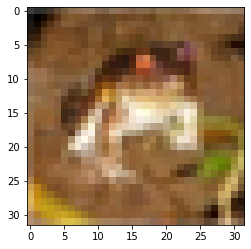

In [2]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

In [29]:
model = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3),pooling='max') 

In [30]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [34]:
batch_size = 64
def get_features(i) : 
  
  reshaped_img = X_train[i].reshape(1,32,32,3)
  # passage vers le modele
  imgx = preprocess_input(reshaped_img)
  # get le vecteur de feature
  features = model.predict(imgx, use_multiprocessing=True)
  return features
  

In [35]:
print(y_train)

[6 9 9 ... 9 1 1]


In [36]:
data = {}
for i in range(n_training):
  feat = get_features(i)
  data[i] = feat

feat = np.array(list(data.values()))
feat.shape

(50000, 1, 1, 1, 512)

In [13]:
X_train[0].shape

(32, 32, 3)

In [37]:
feat[0:3]

array([[[[[38.739204 , 96.806465 ,  5.194613 , ...,  0.       ,
            0.       ,  0.       ]]]],



       [[[[22.418547 ,  0.       ,  0.       , ...,  0.       ,
            0.       ,  0.       ]]]],



       [[[[12.937459 ,  0.       ,  0.       , ...,  0.       ,
            0.       ,  0.2391459]]]]], dtype=float32)

In [39]:
np.savez('feat.npz',feat)

In [40]:
feat.flatten()

array([38.739204, 96.806465,  5.194613, ...,  0.      ,  0.      ,
        0.      ], dtype=float32)

In [41]:
feat.shape

(50000, 1, 1, 1, 512)

In [43]:
feat = feat.reshape(-1,512)

In [44]:
feat.shape

(50000, 512)

In [45]:
pca = PCA(n_components=150, random_state=42)
pca.fit(feat)
x = pca.transform(feat)

In [46]:
kmeans = KMeans(n_clusters=10,init='k-means++')
kmeans.fit(x)

KMeans(n_clusters=10)

In [47]:
def classifier_summary(y_test, y_pred_test):

    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),4)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),4)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),4)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),4) 
    homogeneity = np.round(homogeneity_score(y_test, y_pred_test),4)
    test_confusion_matrix = confusion_matrix(y_test,y_pred_test)
    

    
    

    
    print()
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Humogeneity : {}".format(homogeneity))
    print("Confusion Matrix : {}".format(test_confusion_matrix))

    print("-"*80)
    print()

    return homogeneity

In [48]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  


In [50]:
def infer_data_labels(Y_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(Y_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(Y_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [51]:
clusters = [10, 16, 36, 64,144,200]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    
   
    iner_list.append(kmeans.inertia_)
    
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(kmeans, y_train)
    prediction = infer_data_labels(kmeans.labels_, cluster_labels)
    homo = classifier_summary(y_train, prediction)
    homo_list.append(homo)

    acc = accuracy_score(y_train, prediction)
    acc_list.append(acc)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 30.070000000000004%
F1_score : 0.2721
Cohen Kappa Score : 0.223 
Recall : 0.3007
Precision : 0.2619
Humogeneity : 0.184
Confusion Matrix : [[2382  273    0  602  150   45   37    0 1349  162]
 [ 384 2075    0  214   69   93   26    0  806 1333]
 [1061  142    0 1607 1192  295  430    0  209   64]
 [ 377  309    0 1777  271 1064  715    0  303  184]
 [ 429   35    0 1365 1878  124  570    0  563   36]
 [ 312   98    0 1465  350 1778  696    0   81  220]
 [ 203  111    0 1640 1663  158 1132    0   37   56]
 [ 891   76    0 1603  740  255  646    0  685  104]
 [ 748  818    0  406   53   38   61    0 2474  402]
 [ 347  739    0  309   94   18   38    0 1918 1537]]
--------------------------------------------------------------------------------


------------------------ Test Set Metrics------------------------

accuracy : 36.22%
F1_score : 0.3573
Cohen Kappa Score : 0.2913 
Recall : 0.3622
Precision : 0.3662
Hu

Num cluster  10


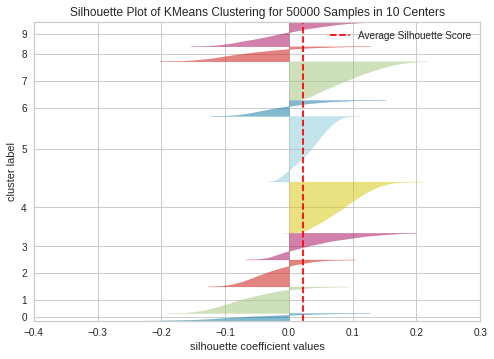

Num cluster  16


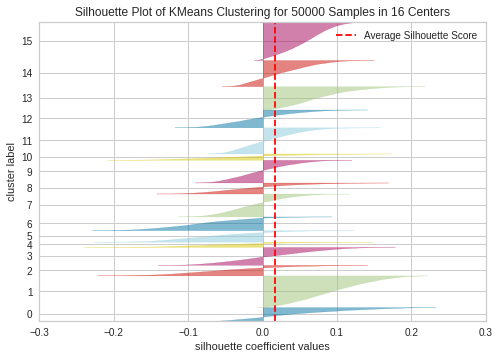

Num cluster  36


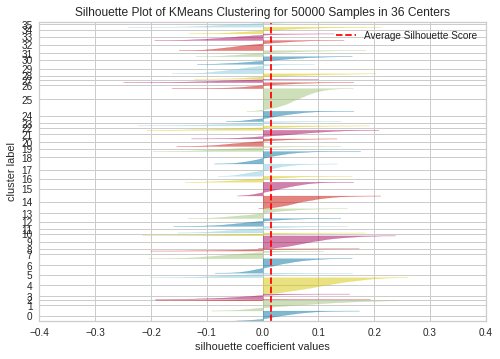

Num cluster  64


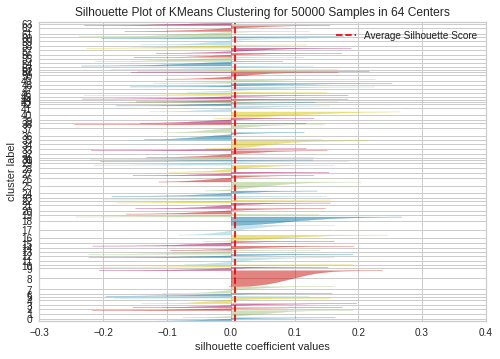

Num cluster  144


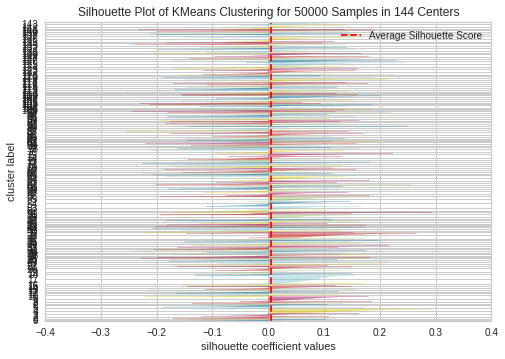

Num cluster  200


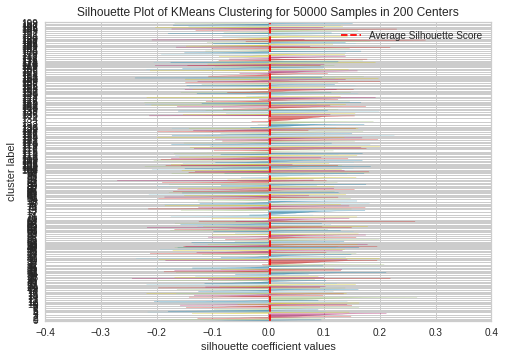

In [ ]:
from yellowbrick.cluster.silhouette import silhouette_visualizer

#fig, ax = plt.subplots(3, 2, figsize=(15,8))
j = 2
for i in clusters:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', random_state=42)
    km.fit(x)
    score = silhouette_samples(x, km.labels_, metric='euclidean')
    print('Num cluster ',i)
    q, mod = divmod(j, 2)
    j+=1
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = silhouette_visualizer(km, colors='yellowbrick',X=x,y=y_train, is_fitted='auto',show=True)